<a href="https://colab.research.google.com/github/shreyash-99/EVA8/blob/main/Session_4_Assignment_1/n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms

Target 
1. Get the set up and basic skeleton right and creating a light model 
2. Set tranforms 
3. Create dataloader, working code, training and teasting loop
4. applying all the necessary things such as batchnorm, dividing code in 4 blocks , using maxpooling etc.


In [3]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081, ))])


In [4]:
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA available" , cuda)

#for Reproducibilty
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# setting the dataloader arguments for both test and train data
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4, pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

train_dataloader = torch.utils.data.DataLoader(train , **dataloader_args)
test_dataloader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA available True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
images,labels = next(iter(train_dataloader))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


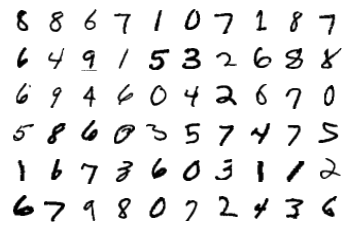

In [14]:
import numpy as np
import matplotlib.pyplot as plt

num_of_images = 60
for index in range(1, num_of_images + 1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap = 'gray_r')

# print(labels)


### **The Model**


In [36]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    ## INPUT BLOCK (BLOCK  1 )
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU()   
    )# input - 28, output - 28
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )#input - 28 , output - 28
    

    # TRANSITION BLOCK 
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 4, kernel_size = (1,1)),
        nn.BatchNorm2d(4),
        nn.ReLU()
    )# input - 28 , output - 28
    self.pool1 = nn.MaxPool2d(2, 2)
    # input 28, output - 144

    #  CONVOLUTION  BLOCK 2
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels = 4, out_channels = 8 , kernel_size = (3,3)),
        nn.BatchNorm2d(8),
        nn.ReLU()#input = 14 , output  = 12
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3)),
        nn.BatchNorm2d(16),
        nn.ReLU()# input - 12 , output = 10
    )
    
    #   TRANSITION BLOCK 
    self.conv6 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 4, kernel_size = (1,1)),
        nn.BatchNorm2d(4),
        nn.ReLU() # input - 10, output - 10
    )
    self.pool2 = nn.MaxPool2d(2,2) #input 10, output 5

    #   CONVOLUTION BLOCK 3

    self.conv7 = nn.Sequential(
        nn.Conv2d(in_channels = 4, out_channels = 8 , kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU()#input = 5, output = 5
    )
    self.conv8 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels = 16, kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU()#input = 5, output = 5
    )

    #     Transition Block
    self.conv9 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 4, kernel_size = (1,1)),
        nn.BatchNorm2d(4),
        nn.ReLU() # input - 5, output - 5
    )
    # self.pool3 = nn.MaxPool2d(2,2) #input 6, output 3

    #       CONVOLUTION BLOCK 4

    self.conv10 = nn.Sequential(
        nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = (3,3), padding= 1),
        nn.BatchNorm2d(8),
        nn.ReLU()
    )#input = 5, output 5
    self.conv11 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3)),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )# input 5 , output 3

    self.conv12 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (3,3))
    )
    


  def forward(self, x ):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.pool1(x)

    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.pool2(x)

    x = self.conv7(x)
    x = self.conv8(x)
    x = self.conv9(x)
    # x = self.pool3(x)

    x = self.conv10(x)
    x = self.conv11(x)
    x = self.conv12(x)

    x = x.view(-1,10)
    return F.log_softmax(x, dim = -1)




In [37]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size = (1,28,28))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           1,168
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
            Conv2d-7            [-1, 4, 28, 28]              68
       BatchNorm2d-8            [-1, 4, 28, 28]               8
              ReLU-9            [-1, 4, 28, 28]               0
        MaxPool2d-10            [-1, 4, 14, 14]               0
           Conv2d-11            [-1, 8, 12, 12]             296
      BatchNorm2d-12            [-1, 8, 12, 12]              16

In [38]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_dataloader, optimiser, epoch):
  model.train()
  pbar = tqdm(train_dataloader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    #get samples
    data, target = data.to(device), target.to(device)

    #init
    optimiser.zero_grad()

    #prediction
    y_pred = model(data)

    #calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    #Backpropagation
    loss.backward()
    optimiser.step()

    # update pbar - tqdm

    pred = y_pred.argmax(dim = 1, keepdim = True) # gets the index of the max log-probabilirty
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_dataloader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_dataloader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_dataloader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_dataloader.dataset),
    100. * correct / len(test_dataloader.dataset)))
  
  test_acc.append(100. * correct / len(test_dataloader.dataset))




In [41]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_dataloader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.0659426674246788 Batch_id=468 Accuracy=92.35: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]



Test set: Average loss: 0.0965, Accuracy: 9695/10000 (96.95%)

EPOCH: 1


Loss=0.052873145788908005 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]



Test set: Average loss: 0.0535, Accuracy: 9842/10000 (98.42%)

EPOCH: 2


Loss=0.05941098928451538 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]



Test set: Average loss: 0.0501, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.005503728520125151 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]



Test set: Average loss: 0.0545, Accuracy: 9818/10000 (98.18%)

EPOCH: 4


Loss=0.07047614455223083 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]



Test set: Average loss: 0.0452, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Loss=0.018294747918844223 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]



Test set: Average loss: 0.0423, Accuracy: 9870/10000 (98.70%)

EPOCH: 6


Loss=0.021709101274609566 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]



Test set: Average loss: 0.0381, Accuracy: 9861/10000 (98.61%)

EPOCH: 7


Loss=0.04314659535884857 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]



Test set: Average loss: 0.0380, Accuracy: 9878/10000 (98.78%)

EPOCH: 8


Loss=0.003224683925509453 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]



Test set: Average loss: 0.0306, Accuracy: 9891/10000 (98.91%)

EPOCH: 9


Loss=0.006965493317693472 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]



Test set: Average loss: 0.0389, Accuracy: 9862/10000 (98.62%)

EPOCH: 10


Loss=0.017300236970186234 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]



Test set: Average loss: 0.0380, Accuracy: 9884/10000 (98.84%)

EPOCH: 11


Loss=0.006190266460180283 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]



Test set: Average loss: 0.0316, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


Loss=0.046676065772771835 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]



Test set: Average loss: 0.0368, Accuracy: 9881/10000 (98.81%)

EPOCH: 13


Loss=0.03701046481728554 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]



Test set: Average loss: 0.0360, Accuracy: 9894/10000 (98.94%)

EPOCH: 14


Loss=0.011274625547230244 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]



Test set: Average loss: 0.0373, Accuracy: 9890/10000 (98.90%)

EPOCH: 15


Loss=0.0035534033086150885 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]



Test set: Average loss: 0.0338, Accuracy: 9886/10000 (98.86%)

EPOCH: 16


Loss=0.013752543367445469 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]



Test set: Average loss: 0.0362, Accuracy: 9884/10000 (98.84%)

EPOCH: 17


Loss=0.0009720734669826925 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]



Test set: Average loss: 0.0361, Accuracy: 9883/10000 (98.83%)

EPOCH: 18


Loss=0.0043942746706306934 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]



Test set: Average loss: 0.0321, Accuracy: 9895/10000 (98.95%)

EPOCH: 19


Loss=0.05765047296881676 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]



Test set: Average loss: 0.0325, Accuracy: 9898/10000 (98.98%)



Results
1. Parameters: 7.5k
2. Best Train Accuracy: 99.50
3. Best Test Accuracy: 98.95

Analysis
1. Model is overfitting, will try to reduce the gap between train and test accuracy using dropout.
2. Model is light, so for increasing the accuracies, we can make our model a little heavy by increasing the kernel sizes
3. We can GAP layer also but will implement it later, and as implementing gap will reduce the parameters whcich can help us to increase channels also and make our model a little heavy
